In [138]:
import json

import mlflow
import pandas as pd
from lightgbm import LGBMRegressor
from mlem.api import save
from pandas_profiling import ProfileReport
from pycaret.regression import (
    compare_models,
    create_model,
    eda,
    evaluate_model,
    get_config,
    interpret_model,
    tune_model,
    plot_model,
    setup,
    set_config,
)
from pycaret.internal.preprocess.transformers import TransformerWrapper
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_validate, KFold, train_test_split

***

### Config

In [2]:
# Some houskeeping stuff
mlflow.set_tracking_uri("http://mlflow:5000")
MODELS = ["lr", "lightgbm", "rf", "et", "dummy", "xgboost"]
SESSION_ID = 42

# Will use this dataframe to train a baseline model
raw_data = pd.read_csv("house_prices.csv", dtype={"spaciousness": "int64"})

# This data will be used for training the candidate model(s).
data = pd.read_csv("house_prices.csv", dtype={"spaciousness": "int64"})
data = data.rename(columns={"sale_price": "target"})

### Examine pandas_profiling report

In [87]:
ProfileReport(raw_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

***

### Raw dataset adjustments

By looking at the profile above, we can identify some irregularities with the dataset. In order to have a cleaner dataset, the folowing changes were made:

- Removed `has_pool` since it has constant 0 value
- Removed `liv_lot_ratio` as being binary does not match with the feature's description of being a ratio
- Removed negative `remodel_age` values
- Only `house_age` greater or equal to `garage_age`, assuming garage can not be older than the house

In [3]:
data = data.drop(columns=[
    "has_pool",
    "liv_lot_ratio",
])
data = data[data["remodel_age"] >= 0]
data = data[(data["house_age"] >= data["garage_age"]) | (data["garage_age"].isna())]
data.shape

(33011, 16)

***

### Baseline

Test multiple models with base dataset

In [65]:
setup(
    data,
    session_id=SESSION_ID,
    target="target",
    log_experiment=True,
)
baseline = compare_models(include=MODELS)

***

### Custom preprocessing

Let's create a custom preprocessing pipeline and test it with the best previous model

In [74]:
categorical_columns = ["house_style", "neighborhood"]
numeric_columns = [
    "property_area",
    "house_age",
    "spaciousness",
    "remodel_age",
    "bath_area",
    "bsmt_area",
    "garage_area",
    "garage_age",
]
ordinal_columns = [
    "overall_quality",
    "overall_condition"
]
binary_columns = [
    "has_2ndfloor",
    "has_porch",
    "has_multiple_kitchen",
]

preprocessing = Pipeline([
    ("categorical_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="most_frequent"), include=categorical_columns)),
    ("numerical_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="mean"), include=numeric_columns)),
    ("ordinal_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="median"), include=ordinal_columns)),
    ("binary_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="most_frequent"), include=binary_columns)),
    ("categorical_encoding", TransformerWrapper(transformer=OneHotEncoder(drop="first", handle_unknown="infrequent_if_exist"), include=categorical_columns)),
])

setup(
    data,
    session_id=SESSION_ID,
    target="target",
    log_experiment=True,
    transform_target=True,
    preprocess=False,
    custom_pipeline=preprocessing,
)

candidate = create_model("lightgbm")

***

### Tuning

Finally, let's fine tune the model to see if we can get even better performance

In [76]:
tuned = tune_model(candidate, search_library="optuna")

[I 2023-02-13 04:34:44,647] Searching the best hyperparameters using 23107 samples...


[LightGBM] [Warning] bagging_fraction is set=0.988402316613221, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988402316613221
[LightGBM] [Warning] feature_fraction is set=0.43097715211874027, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43097715211874027
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.739861423210796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.739861423210796
[LightGBM] [Warning] feature_fraction is set=0.5812408081167499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5812408081167499
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.5748291295024801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5748291295024801
[LightGBM] [Warning] feature_fraction

[I 2023-02-13 04:38:52,392] Finished hyperparemeter search!


### Model evaluation and explainability

In [89]:
evaluate_model(tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

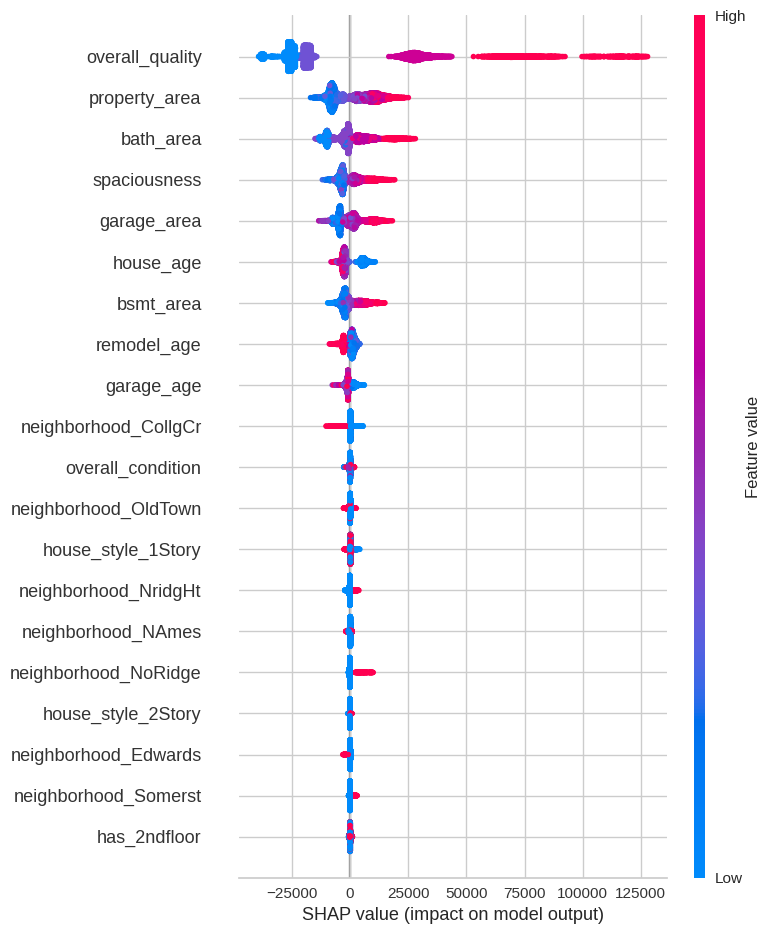

In [90]:
interpret_model(tuned)

### Train-test metrics

We first append the best performing model to the preprocessing pipeline.

In [82]:
preprocessing.steps.append(("estimator", tuned))

We will now fit the best model and get the train and test metrics

In [141]:
X = get_config("X")
y = get_config("y")

results = cross_validate(
    preprocessing,
    X,
    y,
    cv=KFold(n_splits=10, random_state=SESSION_ID, shuffle=True),
    return_train_score=True,
    scoring=[
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
        "r2",
        "neg_mean_absolute_percentage_error",
    ]
)

[LightGBM] [Warning] bagging_fraction is set=0.7821809560485391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821809560485391
[LightGBM] [Warning] feature_fraction is set=0.8632178882589737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632178882589737
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7821809560485391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821809560485391
[LightGBM] [Warning] feature_fraction is set=0.8632178882589737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8632178882589737
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7821809560485391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7821809560485391
[LightGBM] [Warning] feature_fracti

Generate a DataFrame for easy access to the results

In [142]:
results = pd.DataFrame(results)
results = pd.concat([results, results.mean().to_frame(name="mean").T])
results = pd.concat([results, results.std().to_frame(name="std").T])
results

fit_time  score_time  test_neg_mean_absolute_error  \
0     1.446956    0.046613                 -25474.426312   
1     2.140821    0.035460                 -25288.865555   
2     2.458652    0.053057                 -25141.088240   
3     2.122803    0.040684                 -25152.175169   
4     1.248841    0.033882                 -25226.883624   
5     1.830260    0.043754                 -25223.842677   
6     1.847614    0.035266                 -24703.717426   
7     2.670735    0.041032                 -25289.382969   
8     2.408789    0.044608                 -24800.797989   
9     2.113386    0.043083                 -24624.365002   
mean  2.028886    0.041744                 -25092.554496   
std   0.422955    0.005573                    268.293522   

      train_neg_mean_absolute_error  test_neg_mean_squared_error  \
0                     -23849.963780                -1.137837e+09   
1                     -23883.740965                -1.151430e+09   
2                     -23913.904167                -1.136499e+09   
3                     -23893.344981                -1.147231e+09   
4                     -23882.813992                -1.174302e+09   
5                     -23883.754982                -1.165886e+09   
6                     -23925.559041                -1.119465e+09   
7                     -23872.627010                -1.214145e+09   
8                     -23905.225054                -1.086029e+09   
9                     -23942.258192                -1.111718e+09   
mean                  -23895.319216                -1.144454e+09   
std                       25.615148                 3.388230e+07   

      train_neg_mean_squared_error  test_neg_root_mean_squared_error  \
0                    -1.023772e+09                     -33731.835231   
1                    -1.023429e+09                     -33932.722718   
2                    -1.025617e+09                     -33711.999667   
3                    -1.024887e+09                     -33870.804462   
4                    -1.020678e+09                     -34268.087391   
5                    -1.021610e+09                     -34145.072286   
6                    -1.026300e+09                     -33458.405413   
7                    -1.017135e+09                     -34844.585371   
8                    -1.028441e+09                     -32954.951904   
9                    -1.026440e+09                     -33342.439956   
mean                 -1.023831e+09                     -33826.090440   
std                   3.135814e+06                        499.770507   

      train_neg_root_mean_squared_error   test_r2  train_r2  \
0                         -31996.436589  0.761520  0.779795   
1                         -31991.082820  0.753626  0.780412   
2                         -32025.255569  0.757093  0.779915   
3                         -32013.857322  0.765000  0.779002   
4                         -31948.044054  0.747837  0.781086   
5                         -31962.629461  0.757681  0.780068   
6                         -32035.913582  0.743816  0.781378   
7                         -31892.556641  0.742031  0.781584   
8                         -32069.310119  0.763977  0.779715   
9                         -32038.102483  0.750456  0.780906   
mean                      -31997.318864  0.754304  0.780386   
std                           49.026246  0.007726  0.000788   

      test_neg_mean_absolute_percentage_error  \
0                                   -0.152864   
1                                   -0.156310   
2                                   -0.156550   
3                                   -0.153734   
4                                   -0.154975   
5                                   -0.152242   
6                                   -0.152086   
7                                   -0.153848   
8                                   -0.151226   
9                                   -0.150333   
mean                                -0.15341

Generate a model summary

In [134]:
usi = get_config("USI")
model_summary = {
    "artifact": {
        "model": "lightgbm",
        "usi": usi,
    },
    "cv": {
        "folds": 10,
        "random_state": SESSION_ID,
        "strategy": "KFold",
    },
    "train": {
        "r2": {
            "mean": results.loc["mean", "train_r2"],
            "std": results.loc["std", "train_r2"],
        },
        "mae": {
            "mean": results.loc["mean", "train_neg_mean_absolute_error"] * -1,
            "std": results.loc["std", "train_neg_mean_absolute_error"],
        },
        "mse": {
            "mean": results.loc["mean", "train_neg_mean_squared_error"] * -1,
            "std": results.loc["std", "train_neg_mean_squared_error"],
        },
        "rmse": {
            "mean": results.loc["mean", "train_neg_root_mean_squared_error"] * -1,
            "std": results.loc["std", "train_neg_root_mean_squared_error"],
        },
    },
    "test": {
        "r2": {
            "mean": results.loc["mean", "test_r2"],
            "std": results.loc["std", "test_r2"],
        },
        "mae": {
            "mean": results.loc["mean", "test_neg_mean_absolute_error"] * -1,
            "std": results.loc["std", "test_neg_mean_absolute_error"],
        },
        "mse": {
            "mean": results.loc["mean", "test_neg_mean_squared_error"] * -1,
            "std": results.loc["std", "test_neg_mean_squared_error"],
        },
        "rmse": {
            "mean": results.loc["mean", "test_neg_root_mean_squared_error"] * -1,
            "std": results.loc["std", "test_neg_root_mean_squared_error"],
        },
    },
}

### Serialization

Finally, we save the artifact

In [137]:
save(preprocessing, f"models/{usi}_model")

MlemModel(location=Location(path='/app/models/b1ad_model.mlem', project=None, rev=None, uri='file:///app/models/b1ad_model.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0xfffe503e2200>), params={}, artifacts={'data': LocalArtifact(uri='b1ad_model', size=2211857, hash='3f8462cdf82af10becaf39dd04cfcc4c')}, requirements=Requirements(__root__=[InstallableRequirement(module='sklearn', version='1.2.1', package_name='scikit-learn', extra_index=None), InstallableRequirement(module='pycaret', version='3.0.0.rc9', package_name=None, extra_index=None), UnixPackageRequirement(package_name='libgomp1'), InstallableRequirement(module='lightgbm', version='3.3.5', package_name=None, extra_index=None)]), processors_cache={'model': SklearnPipelineType(model=Pipeline(steps=[('categorical_imputer',
                 TransformerWrapper(include=['house_style', 'neighborhood'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
     

And the model summary

In [140]:
with open(f"models/{usi}_summary.json", "w+") as f:
    json.dump(model_summary, f)